Nama : M. Iqbal Baskoro

# Project 3 - Voice Recognition

## Data & Algoritma Understanding

In [ ]:
# Mengimpor library standar
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display

# Mengimpor komponen dari PyTorch
import torch

# Mengimpor komponen dari Hugging Face
from datasets import load_dataset, Audio as DatasetsAudio, ClassLabel
from transformers import (
    Wav2Vec2FeatureExtractor,
    Wav2Vec2ForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate

# Fungsi untuk hasil yang reproducible
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


In [3]:
print("Memuat dataset MINDS-14...")
dataset = load_dataset("PolyAI/minds14", name="en-US", split="train")
print("\nDataset berhasil dimuat:")
print(dataset)

Memuat dataset MINDS-14...

Dataset berhasil dimuat:
Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})


In [4]:
print("\nMengubah dataset menjadi DataFrame Pandas...")
df = dataset.to_pandas()

print("5 baris pertama dari DataFrame:")
display(df.head())

csv_path = "../data/minds14_en-US.csv"
print(f"\nMenyimpan DataFrame ke file '{csv_path}'...")
df.to_csv(csv_path, index=False)
print("Berhasil disimpan!")


Mengubah dataset menjadi DataFrame Pandas...
5 baris pertama dari DataFrame:


,path,audio,transcription,english_transcription,intent_class,lang_id
0,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,"{'bytes': None, 'path': 'C:\Users\SUWAAAN\.cac...",I would like to set up a joint account with my...,I would like to set up a joint account with my...,11,4
1,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,"{'bytes': None, 'path': 'C:\Users\SUWAAAN\.cac...",Henry County set up a joint account with my wi...,Henry County set up a joint account with my wi...,11,4
2,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,"{'bytes': None, 'path': 'C:\Users\SUWAAAN\.cac...",hi I'd like to set up a joint account with my ...,hi I'd like to set up a joint account with my ...,11,4
3,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,"{'bytes': None, 'path': 'C:\Users\SUWAAAN\.cac...",how do I start a joint account,how do I start a joint account,11,4
4,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,"{'bytes': None, 'path': 'C:\Users\SUWAAAN\.cac...",can you help me set up a joint bank account,can you help me set up a joint bank account,11,4



Menyimpan DataFrame ke file '../data/minds14_en-US.csv'...
Berhasil disimpan!


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   path                   563 non-null    object
 1   audio                  563 non-null    object
 2   transcription          563 non-null    object
 3   english_transcription  563 non-null    object
 4   intent_class           563 non-null    int64 
 5   lang_id                563 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 26.5+ KB


#### <Strong>Data Field</Strong>

| Nama Kolom | Tipe Data | Keterangan |
|:----------:|:---------:|:----------:|
|`path `| String | Path to the audio file |
|`audio `| Dict | Audio object including loaded audio array, sampling rate and path ot audio |
|`transcription `| String | Transcription of the audio file |
|`english_transcription `| String | English transcription of the audio file |
|`intent_class `| Integer | Class id of intent |
|`lang_id `| Integer | Id of language |

#### <strong>Penggunaan Bahasa Pada Dataset</strong>
-`en-US`

#### <strong>Pengolahan Dataset</strong>
-`Pembagian Dataset` = <strong>Training</strong>(70%), <strong>Validation</strong>(15%), dan <strong>Test</strong>(15%) <br>
-`Audio Preprocessing` = <strong>Resampling</strong>, Audio diseragamkan ke sampling rate 16000 Hz <br>
-`Ekstraksi Fitur` = Audio Mentah diubah menjadi <strong>MFCC</strong>(Mel-Frequency Cepstral Coefficients) yaitu representasi ringkas dari spektrum suara yang lebih mudah dipelajari oleh model dibandingkan data gelombang mentah <br>
-`Normalisasi` = Fitur Hasil <strong>MFCC</strong> dinormalisasi menggunakan <italic>mean</italic> dan <italic>standard deviation</italic>

In [6]:
sample = dataset[0]
print("\nStruktur satu sampel data:")
for key, value in sample.items():
    print(f"  - {key}: {value}")

# Mendapatkan daftar nama kelas/intent dari fitur dataset.
intent_names = dataset.features['intent_class'].names
num_intents = len(intent_names)
print(f"\nDaftar Intent ({num_intents} kelas):")
print(intent_names)

# Memainkan salah satu file audio untuk mendengar sampel dan melihat labelnya.
print("\nMemainkan audio sampel:")
print(f"Transkripsi: '{sample['english_transcription']}'")
print(f"Intent: {intent_names[sample['intent_class']]}")

# Baris ini akan menampilkan pemutar audio di dalam notebook.
# Ini berfungsi karena kita sudah memperbaiki konflik nama 'Audio' pada sel import.
display(Audio(sample['audio']['array'], rate=sample['audio']['sampling_rate']))


Struktur satu sampel data:
  - path: C:\Users\SUWAAAN\.cache\huggingface\datasets\downloads\extracted\8bc9a751a3afbab102112966351b66fd3b6d28de588303c438501942c87ba24e\en-US~JOINT_ACCOUNT\602ba55abb1e6d0fbce92065.wav
  - audio: {'path': 'C:\\Users\\SUWAAAN\\.cache\\huggingface\\datasets\\downloads\\extracted\\8bc9a751a3afbab102112966351b66fd3b6d28de588303c438501942c87ba24e\\en-US~JOINT_ACCOUNT\\602ba55abb1e6d0fbce92065.wav', 'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
        0.        ,  0.        ]), 'sampling_rate': 8000}
  - transcription: I would like to set up a joint account with my partner
  - english_transcription: I would like to set up a joint account with my partner
  - intent_class: 11
  - lang_id: 4

Daftar Intent (14 kelas):
['abroad', 'address', 'app_error', 'atm_limit', 'balance', 'business_loan', 'card_issues', 'cash_deposit', 'direct_debit', 'freeze', 'high_value_payment', 'joint_account', 'latest_transactions', 'pay_bill']

Memainkan aud

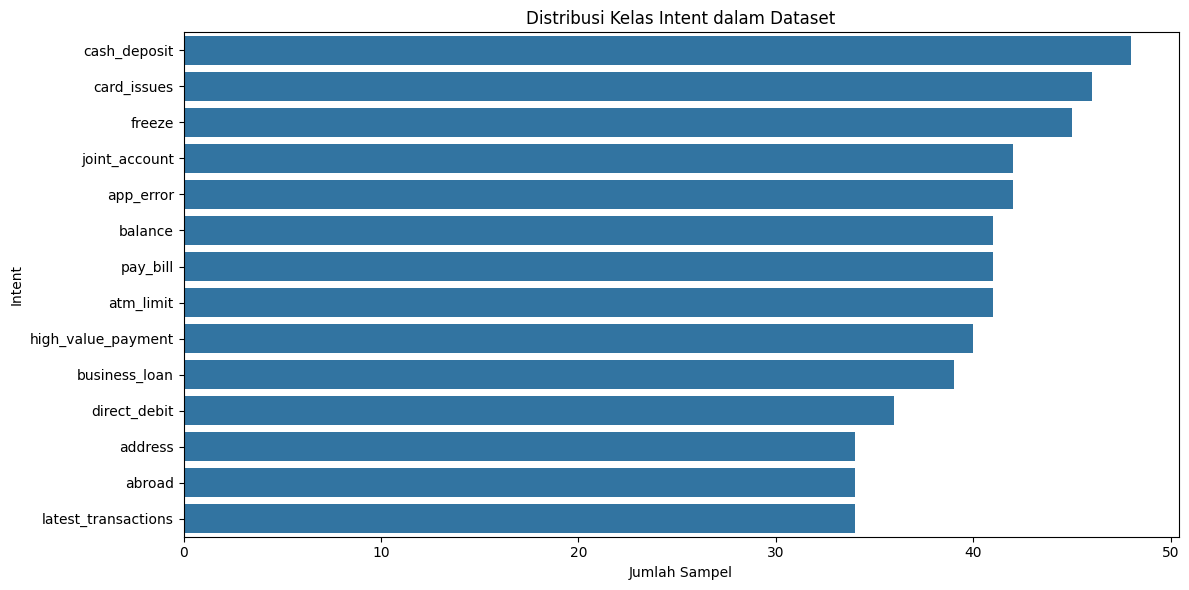

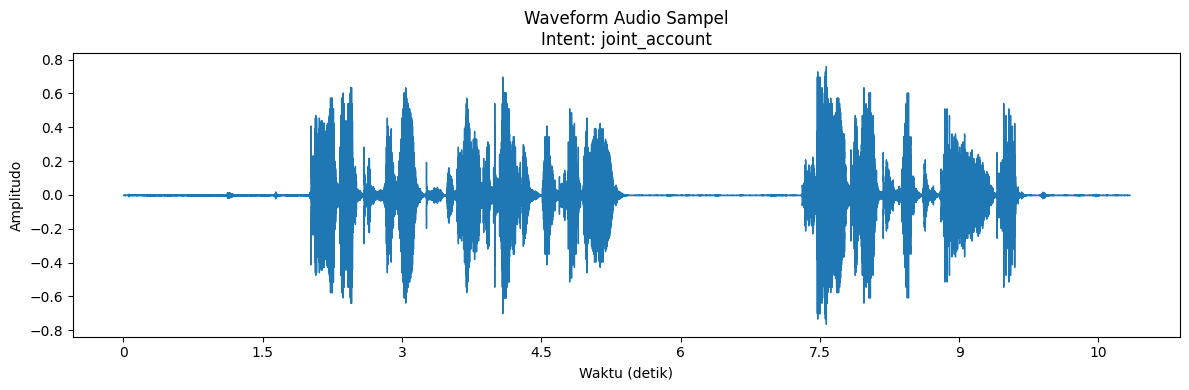

In [7]:
# Visualisasi Distribusi Intent
# Ini membantu kita melihat apakah dataset kita seimbang atau ada kelas yang sangat dominan.
intent_labels = [intent_names[i] for i in dataset['intent_class']]

plt.figure(figsize=(12, 6))
sns.countplot(y=intent_labels, order=pd.Series(intent_labels).value_counts().index)
plt.title('Distribusi Kelas Intent dalam Dataset')
plt.xlabel('Jumlah Sampel')
plt.ylabel('Intent')
plt.tight_layout()
plt.show()

# Visualisasi Waveform Audio
# Waveform adalah representasi visual dari amplitudo audio seiring waktu.
y = sample['audio']['array']
sr = sample['audio']['sampling_rate']

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'Waveform Audio Sampel\nIntent: {intent_names[sample["intent_class"]]}')
plt.xlabel('Waktu (detik)')
plt.ylabel('Amplitudo')
plt.tight_layout()
plt.show()

## Model Training & Evaluation

#### Import Library

In [1]:
# Install dan Import Library
!pip install datasets librosa torch torchaudio soundfile scikit-learn jiwer matplotlib -q

import os, random
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.preprocessing import OneHotEncoder
from datasets import load_dataset, Audio
from jiwer import wer, cer
from collections import Counter
from difflib import SequenceMatcher

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Konfigurasi 
LANG = 'en-US'
SAMPLE_RATE = 16000
N_MFCC = 13
BATCH_SIZE = 128
NUM_EPOCHS = 100
LEARNING_RATE = 2e-5

In [3]:
# Load dataset & split
raw_dataset = load_dataset("PolyAI/minds14", LANG, trust_remote_code=True)

# Split data: 70% train, 15% validation, 15% test
train_test_split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
train_data = train_test_split['train']
test_valid_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
val_data = test_valid_split['train']
test_data = test_valid_split['test']

# Pastikan audio dikonversi ke sample rate yang sesuai
train_data = train_data.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))
val_data = val_data.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))
test_data = test_data.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))

print(f"Ukuran data train: {len(train_data)}")
print(f"Ukuran data validasi: {len(val_data)}")
print(f"Ukuran data test: {len(test_data)}")

Ukuran data train: 394
Ukuran data validasi: 84
Ukuran data test: 85


In [4]:
# Token mapping
transcript_col = "transcription"
# Buat vocabulary dari semua karakter unik di data training
all_text = "".join(ex[transcript_col].lower() for ex in train_data)
tokens = sorted(list(set(all_text)))

# Buat mapping karakter ke integer dan sebaliknya
char2idx = {c: i for i, c in enumerate(tokens)}
idx2char = {i: c for i, c in enumerate(tokens)}

# Tambahkan token 'blank' untuk CTC loss. ID-nya adalah ID terakhir.
BLANK_TOKEN_ID = len(tokens)
char2idx['<blank>'] = BLANK_TOKEN_ID
idx2char[BLANK_TOKEN_ID] = '<blank>'

vocab_size = len(char2idx)
print(f"Ukuran Vocab: {vocab_size}")
print(f"Karakter unik: {''.join(tokens)}")
print(f"ID untuk token <blank>: {BLANK_TOKEN_ID}")

Ukuran Vocab: 42
Karakter unik:  $'-.0123456789abcdefghijklmnopqrstuvwxyz
ID untuk token <blank>: 41


In [5]:
# Hitung Statistik Normalisasi dari Data Training
print("Menghitung statistik normalisasi dari seluruh data training...")
all_mfccs_list = []
for example in train_data:
    audio, sr = librosa.load(example['audio']['path'], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC).T
    all_mfccs_list.append(mfcc)

all_mfccs_np = np.vstack(all_mfccs_list)
mfcc_mean = np.mean(all_mfccs_np, axis=0)
mfcc_std = np.std(all_mfccs_np, axis=0)
print("Statistik normalisasi selesai dihitung.")

Menghitung statistik normalisasi dari seluruh data training...
Statistik normalisasi selesai dihitung.


In [6]:
# Memfilter Data yang Tidak Memenuhi Syarat CTC
def is_valid_sample(sample):
    spec_len = len(sample['audio']['array']) // 512 + 1
    
    DOWNSAMPLING_FACTOR = 2
    logit_len = spec_len // DOWNSAMPLING_FACTOR
    
    # Panjang label teks (transkripsi)
    label_len = len(sample['transcription'])
    
    return logit_len >= label_len

print("Memfilter data training...")
original_train_len = len(train_data)
train_data_filtered = train_data.filter(is_valid_sample)
filtered_train_len = len(train_data_filtered)
print(f"Ukuran data train asli: {original_train_len}, setelah difilter: {filtered_train_len}. ({original_train_len - filtered_train_len} sampel dibuang)")

print("\nMemfilter data validasi...")
original_val_len = len(val_data)
val_data_filtered = val_data.filter(is_valid_sample)
filtered_val_len = len(val_data_filtered)
print(f"Ukuran data validasi asli: {original_val_len}, setelah difilter: {filtered_val_len}. ({original_val_len - filtered_val_len} sampel dibuang)")

print("\nMemfilter data test...")
original_test_len = len(test_data)
test_data_filtered = test_data.filter(is_valid_sample)
filtered_test_len = len(test_data_filtered)
print(f"Ukuran data test asli: {original_test_len}, setelah difilter: {filtered_test_len}. ({original_test_len - filtered_test_len} sampel dibuang)")

Memfilter data training...


Filter: 100%|██████████| 394/394 [00:00<00:00, 702.81 examples/s]


Ukuran data train asli: 394, setelah difilter: 387. (7 sampel dibuang)

Memfilter data validasi...


Filter: 100%|██████████| 84/84 [00:00<00:00, 448.57 examples/s]


Ukuran data validasi asli: 84, setelah difilter: 84. (0 sampel dibuang)

Memfilter data test...


Filter: 100%|██████████| 85/85 [00:00<00:00, 616.97 examples/s]

Ukuran data test asli: 85, setelah difilter: 85. (0 sampel dibuang)


In [7]:
# Augmentasi & SpecAugment
def augment(audio, sr):
    noise = np.random.randn(len(audio)) * 0.005
    audio_with_noise = audio + noise
    stretch_rate = random.uniform(0.9, 1.1)
    audio_stretched = librosa.effects.time_stretch(audio_with_noise, rate=stretch_rate)
    pitch_steps = random.randint(-2, 2)
    audio_final = librosa.effects.pitch_shift(audio_stretched, sr=sr, n_steps=pitch_steps)
    return audio_final

def spec_augment(mfcc):
    t, f = mfcc.shape
    time_mask_num = random.randint(10, 25)
    if t > time_mask_num:
        time_mask_start = random.randint(0, t - time_mask_num)
        mfcc[time_mask_start:time_mask_start + time_mask_num, :] = 0
    
    freq_mask_num = random.randint(2, 5)
    if f > freq_mask_num:
        freq_mask_start = random.randint(0, f - freq_mask_num)
        mfcc[:, freq_mask_start:freq_mask_start + freq_mask_num] = 0
        
    return mfcc

In [8]:
# Dataset & Collate (dengan data yang sudah difilter)
class SpeechDataset(Dataset):
    def __init__(self, data, mean, std, augment_prob=0.5):
        self.data = data
        self.mean = mean
        self.std = std + 1e-5
        self.augment_prob = augment_prob
        self.transcript_col = "transcription"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]
        audio_array = ex['audio']['array']
        sr = ex['audio']['sampling_rate']
        
        # Menggunakan audio array langsung
        if random.random() < self.augment_prob:
            audio_array = augment(audio_array, sr)
        mfcc = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=N_MFCC).T
        mfcc = (mfcc - self.mean) / self.std
        
        if random.random() < 0.5 and self.augment_prob > 0:
            mfcc = spec_augment(mfcc)
        return mfcc, ex[self.transcript_col].lower()

def collate_fn(batch):
    specs, texts = zip(*batch)
    spec_lengths = [s.shape[0] for s in specs]
    max_spec_len = max(spec_lengths)
    
    # Padding MFCC/Spectrogram
    padded_specs = [np.pad(s, ((0, max_spec_len - s.shape[0]), (0, 0)), mode='constant') for s in specs]
    X = torch.tensor(padded_specs, dtype=torch.float32)

    # Padding Target/Label
    targets, target_lengths = [], []
    for t in texts:
        # Konversi karakter ke integer
        chars_as_ints = [char2idx[c] for c in t]
        targets.extend(chars_as_ints)
        target_lengths.append(len(chars_as_ints))
        
    # Return target sebagai flat tensor
    y_flat = torch.tensor(targets, dtype=torch.long)
    y_lens = torch.tensor(target_lengths, dtype=torch.long)
    return X, torch.tensor(spec_lengths), y_flat, y_lens

# Gunakan data yang sudah difilter
train_dataset = SpeechDataset(train_data_filtered, mfcc_mean, mfcc_std, augment_prob=0.5)
val_dataset = SpeechDataset(val_data_filtered, mfcc_mean, mfcc_std, augment_prob=0.0)
test_dataset = SpeechDataset(test_data_filtered, mfcc_mean, mfcc_std, augment_prob=0.0)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)

In [9]:
# Model BiLSTM
class CNNBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, n_mfcc, rnn_dim=128, rnn_layers=2, dropout=0.15):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1, stride=(2, 2)), 
            nn.GELU(),
            nn.BatchNorm2d(32), # Tambah BatchNorm untuk stabilitas
            nn.Dropout(dropout)
        )
        # Hitung ukuran output frekuensi dari Conv layer 
        conv_out_freq = (n_mfcc + 2 * 1 - 3) // 2 + 1
        rnn_input_size = 32 * conv_out_freq
        
        self.rnn = nn.LSTM(rnn_input_size, rnn_dim, num_layers=rnn_layers, 
                           bidirectional=True, batch_first=True, dropout=dropout)
        self.norm = nn.LayerNorm(rnn_dim * 2)
        self.fc = nn.Linear(rnn_dim * 2, vocab_size)

    def forward(self, x, lengths):
        x = x.unsqueeze(1) # (batch, 1, time, freq)
        x = self.conv(x)   # (batch, 32, time/2, freq/2)
        
        b, c, t, f = x.size()
        x = x.permute(0, 2, 1, 3).contiguous() # (batch, time/2, 32, freq/2)
        x = x.view(b, t, c * f) # (batch, time/2, 32*freq/2)
        
        # Panjang sekuens berkurang 2x karena stride Conv=(2,2)
        lengths = torch.floor_divide(lengths, 2).cpu() 
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        out, _ = self.rnn(packed)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        unpacked = self.norm(unpacked)
        logits = self.fc(unpacked)
        
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNBiLSTMModel(vocab_size=vocab_size, n_mfcc=N_MFCC).to(device)
print(model)
# Cek rnn_input_size yang baru
print(f"\nUkuran input yang diharapkan oleh RNN: {model.rnn.input_size}")

CNNBiLSTMModel(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.15, inplace=False)
  )
  (rnn): LSTM(224, 128, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=256, out_features=42, bias=True)
)

Ukuran input yang diharapkan oleh RNN: 224


In [10]:
# Training & Evaluasi
import torch.nn.functional as F

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, 
                                          steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS)
criterion = nn.CTCLoss(blank=BLANK_TOKEN_ID, zero_infinity=True)
scaler = GradScaler(enabled=torch.cuda.is_available())

def greedy_decode(logits):
    pred_ids = torch.argmax(logits.log_softmax(dim=-1), dim=-1)
    results = []
    for seq in pred_ids:
        prev_char_id = -1
        decoded_seq = []
        for char_id in seq:
            if char_id != prev_char_id and char_id != BLANK_TOKEN_ID:
                decoded_seq.append(idx2char.get(char_id.item(), ''))
            prev_char_id = char_id
        results.append(''.join(decoded_seq))
    return results

def evaluate(loader):
    model.eval()
    all_preds, all_refs = [], []
    with torch.no_grad():
        for X, spec_lens, y_flat, y_lens in loader:
            X = X.to(device)
            with autocast(device_type=device.type, enabled=torch.cuda.is_available()):
                logits = model(X, spec_lens.cpu())
            preds = greedy_decode(logits.cpu())
            
            idx = 0
            for length in y_lens:
                ref_seq = y_flat[idx:idx+length]
                all_refs.append(''.join([idx2char[int(c)] for c in ref_seq]))
                idx += length
            all_preds.extend(preds)
            
    return wer(all_refs, all_preds), cer(all_refs, all_preds)

train_losses, val_cers, val_wers = [], [], []
best_cer = float('inf')
epochs_no_improve = 0
patience = 10  # Berhenti setelah 5 epoch tidak ada perbaikan

DOWNSAMPLING_FACTOR = 2

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for X, spec_lens, y_flat, y_lens in train_loader:
        X, y_flat, y_lens = X.to(device), y_flat.to(device), y_lens.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type=device.type, enabled=torch.cuda.is_available()):
            logits = model(X, spec_lens.cpu())
            log_probs = F.log_softmax(logits, dim=-1)
            log_probs_permuted = log_probs.permute(1, 0, 2)
            logit_lens = torch.floor_divide(spec_lens, DOWNSAMPLING_FACTOR).to(device)
            loss = criterion(log_probs_permuted, y_flat, logit_lens, y_lens)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    val_wer, val_cer = evaluate(val_loader)
    
    train_losses.append(avg_train_loss)
    val_wers.append(val_wer)
    val_cers.append(val_cer)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Loss {avg_train_loss:.4f}, Val WER {val_wer:.3f}, Val CER {val_cer:.3f}")
    
    # --- EARLY STOPPING ---
    if val_cer < best_cer:
        best_cer = val_cer
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Model terbaik disimpan ke best_model.pth (CER: {best_cer:.3f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"❌ Tidak ada perbaikan. Counter: {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print(f"\n✋ Early stopping dipicu setelah {epoch+1} epoch.")
        break

Epoch 1/100: Loss 6.6589, Val WER 1.000, Val CER 0.920
✅ Model terbaik disimpan ke best_model.pth (CER: 0.920)
Epoch 2/100: Loss 6.9529, Val WER 1.000, Val CER 0.920
✅ Model terbaik disimpan ke best_model.pth (CER: 0.920)
Epoch 3/100: Loss 6.5392, Val WER 1.000, Val CER 0.920
❌ Tidak ada perbaikan. Counter: 1/10
Epoch 4/100: Loss 6.2471, Val WER 1.000, Val CER 0.922
❌ Tidak ada perbaikan. Counter: 2/10
Epoch 5/100: Loss 6.3960, Val WER 1.000, Val CER 0.925
❌ Tidak ada perbaikan. Counter: 3/10
Epoch 6/100: Loss 6.1747, Val WER 1.000, Val CER 0.927
❌ Tidak ada perbaikan. Counter: 4/10
Epoch 7/100: Loss 6.7535, Val WER 1.000, Val CER 0.929
❌ Tidak ada perbaikan. Counter: 5/10
Epoch 8/100: Loss 7.0923, Val WER 1.000, Val CER 0.932
❌ Tidak ada perbaikan. Counter: 6/10
Epoch 9/100: Loss 6.2818, Val WER 1.000, Val CER 0.932
❌ Tidak ada perbaikan. Counter: 7/10
Epoch 10/100: Loss 6.1361, Val WER 1.000, Val CER 0.935
❌ Tidak ada perbaikan. Counter: 8/10
Epoch 11/100: Loss 6.5674, Val WER 1.000,


Final Test WER: 1.000, Final Test CER: 0.894


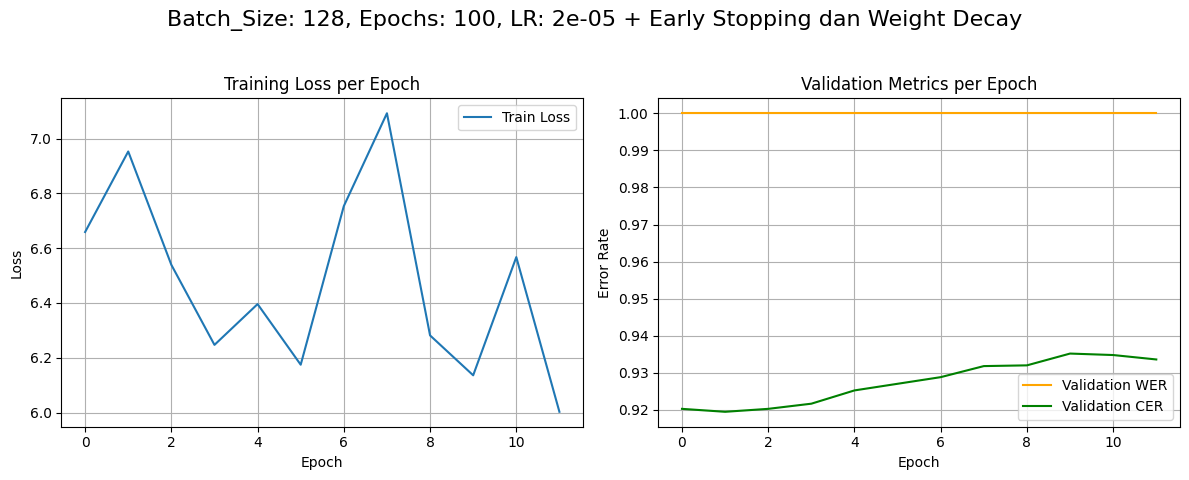

In [11]:
# Evaluasi akhir pada test set
# Evaluasi model terbaik
model.load_state_dict(torch.load("best_model.pth"))
final_wer, final_cer = evaluate(test_loader)
print(f"\nFinal Test WER: {final_wer:.3f}, Final Test CER: {final_cer:.3f}")

# Plotting hasil training
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"Batch_Size: {BATCH_SIZE}, Epochs: {NUM_EPOCHS}, LR: {LEARNING_RATE} + Early Stopping dan Weight Decay", fontsize=16)

# --- Training Loss ---
axs[0].plot(train_losses, label='Train Loss')
axs[0].set_title('Training Loss per Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# --- Validation Metrics ---
axs[1].plot(val_wers, label='Validation WER', color='orange')
axs[1].plot(val_cers, label='Validation CER', color='green')
axs[1].set_title('Validation Metrics per Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Error Rate')
axs[1].legend()
axs[1].grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Sesuaikan agar suptitle tidak tumpang tindih
plt.show()

In [12]:
# Analisis Error (Disesuaikan)

def predict_and_analyze(loader):
    model.eval()
    all_preds, all_refs = [], []
    with torch.no_grad():
        # y_flat, y_lens didapat dari loader baru
        for X, spec_lens, y_flat, y_lens in loader:
            X = X.to(device)
            logits = model(X, spec_lens.cpu())
            preds = greedy_decode(logits.cpu())
            
            # Mendekode referensi dari y_flat
            idx = 0
            for length in y_lens:
                ref_seq = y_flat[idx:idx+length]
                all_refs.append(''.join([idx2char[int(c)] for c in ref_seq]))
                idx += length
            
            all_preds.extend(preds)
            
    return pd.DataFrame({"Reference": all_refs, "Prediction": all_preds})

# Muat kembali model terbaik sebelum analisis
model.load_state_dict(torch.load("best_model.pth"))
results_df = predict_and_analyze(test_loader)
results_df.to_csv("predictions.csv", index=False)
print("Prediksi disimpan ke predictions.csv")

# Analisis Error Karakter (kode ini tidak perlu diubah)
char_errors = Counter()
for _, row in results_df.iterrows():
    ref, hyp = row['Reference'], row['Prediction']
    matcher = SequenceMatcher(None, ref, hyp)
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace':
            for r, h in zip(ref[i1:i2], hyp[j1:j2]): char_errors[f"{r}→{h}"] += 1
        elif tag == 'delete':
            for r in ref[i1:i2]: char_errors[f"{r}→-"] += 1
        elif tag == 'insert':
            for h in hyp[j1:j2]: char_errors[f"-→{h}"] += 1

print("\n15 Kesalahan Karakter Paling Umum:")
for err, count in char_errors.most_common(15):
    print(f"{err}: {count}x")

Prediksi disimpan ke predictions.csv

15 Kesalahan Karakter Paling Umum:
 →-: 241x
a→-: 110x
o→-: 100x
t→-: 81x
i→-: 78x
e→-: 74x
-→n: 68x
n→-: 61x
-→u: 48x
 →5: 42x
-→5: 42x
s→-: 42x
c→-: 38x
m→-: 38x
d→-: 33x
